# 0.0 IMPORTS

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
import webbrowser
import inflection
import pickle

from scipy import stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn import model_selection as ms
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as mt
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from boruta import BorutaPy

## 0.1 Loading Data

In [68]:
path = 'C:/Users/edils/repos/hotel_chain_cancellation/data/'

In [69]:
df_raw = pd.read_csv(path + 'train.csv')

In [70]:
df_raw.head()

,id,Classificação do hotel,Meses da reserva até o check-in,Número de pernoites reservadas,Número de hospedes,Regime de alimentação,Nacionalidade,Forma de Reserva,Já se hospedou anterioremente,Tipo do quarto reservado,Reserva feita por agência de turismo,Reserva feita por empresa,Reserva com Estacionamento,Reserva com Observações,Reserva Cancelada
0,33571,5 estrelas,5,5,2.0,Café da manha e jantar,France,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0
1,82458,4 estrelas,167,3,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
2,94061,4 estrelas,4,3,2.0,Café da manha,Belgium,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,0
3,75196,4 estrelas,13,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
4,82940,4 estrelas,4,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1


## 0.2 Helper Functions

In [71]:
def cramer_v( x, y ):
  cm = pd.crosstab( x, y ).to_numpy()
  n = cm.sum()
  r, k = cm.shape

  chi2 = stats.chi2_contingency( cm )[0]
  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def rename_columns(df1):
    valores_dict = ['id',
                'classificacao', 
                'meses_ate_checkin', 
                'pernoites', 
                'hospedes', 
                'regime_alimentacao',
                'nacionalidade', 
                'forma_reserva', 
                'ja_hospedou',
                'tipo_quarto',
                'reserva_agencia',
                'reserva_empresa',
                'reserva_estacionamento',
                'reserva_observacoes',
                'reserva_cancelada']

    chaves_dict = df1.columns
    cols_new = dict(zip(chaves_dict,valores_dict))
    df1 = df1.rename(columns=cols_new)
    return df1

def na_fill(df1):
    df1['hospedes'] = df1['hospedes'].fillna(2)
    df1['nacionalidade'] = df1['nacionalidade'].fillna('Spain')
    return df1
    
def change_types(df1):
    df1['hospedes'] = df1['hospedes'].astype('int64')
    return df1
    
def data_transformation(df5):

    #Robust Scaler nos que tem outliers
    rb = RobustScaler()

    df5['meses_ate_checkin'] = rb.fit_transform(df5['meses_ate_checkin'].values.reshape(-1,1))
    #pickle.dump( rb, open ('C:/Users/edils/repos/hotel_chain_cancellation/src/features/meses_ate_checkin_scaler.pkl', 'wb'))
    
    df5['pernoites'] = rb.fit_transform(df5['pernoites'].values.reshape(-1,1))
    #pickle.dump( rb, open ('C:/Users/edils/repos/hotel_chain_cancellation/src/features/pernoites_scaler.pkl', 'wb'))
    
    df5['hospedes'] = rb.fit_transform(df5['hospedes'].values.reshape(-1,1))
    #pickle.dump( rb, open ('C:/Users/edils/repos/hotel_chain_cancellation/src/features/hospedes_scaler.pkl', 'wb'))
    

    #MinMax nos que tem distribuição normal
    mms = MinMaxScaler()
    df5['id'] = mms.fit_transform(df5['id'].values.reshape(-1,1))
    #pickle.dump( mms, open ('C:/Users/edils/repos/hotel_chain_cancellation/src/features/id_scaler.pkl', 'wb'))
    
    return df5

def data_encoding(df5):

    #reserva_empresa - Label Encoder
    df5['reserva_empresa'] = df5['reserva_empresa'].apply(lambda x: 1 if x == 'Sim' else 0)

    #reserva_estacionamento - Label Encoder
    df5['reserva_estacionamento'] = df5['reserva_estacionamento'].apply(lambda x: 1 if x == 'Sim' else 0)

    #reserva_estacionamento - Label Encoder
    df5['reserva_agencia'] = df5['reserva_agencia'].apply(lambda x: 1 if x == 'Sim' else 0)

    #ja_hospedou - Label Encoder
    df5['ja_hospedou'] = df5['ja_hospedou'].apply(lambda x: 1 if x == 'Sim' else 0)  
    
    df5['classificacao'] = df5['classificacao'].apply(lambda x: x[0])
    df5['classificacao'] = df5['classificacao'].astype('int64')
    
    #One Hot Encoding - regime_alimentacao
    df5 = pd.get_dummies(df5, prefix='regime_alimentacao', columns=['regime_alimentacao'], dtype=int)

    #One Hot Encoding - reserva_observacoes
    df5 = pd.get_dummies(df5, prefix='reserva_observacoes', columns=['reserva_observacoes'], dtype=int)

    #One Hot Encoding - forma_reserva
    df5 = pd.get_dummies(df5, prefix='forma_reserva', columns=['forma_reserva'], dtype=int)

    df5 = df5.rename(columns={'regime_alimentacao_Café da manha':'cafe_manha',
                       'regime_alimentacao_Café da manha e jantar':'cafe_jantar',
                       'regime_alimentacao_Café da manha, almoco e jantar': 'cafe_almoco_jantar',
                       'regime_alimentacao_Sem refeicao': 'sem_refeicao',
                       'reserva_observacoes_1 a 3': 'obs_1_a_3',
                       'reserva_observacoes_Mais de 3': 'obs_mais_3',
                       'reserva_observacoes_Nenhuma': 'obs_nenhuma',
                       'forma_reserva_Agência': 'forma_reserva_agencia',
                       'forma_reserva_B2B': 'forma_reserva_b2b',
                       'forma_reserva_Balcão': 'forma_reserva_balcao'})
    #nacionalidade - Frequency Encoding
    values_nacionalidade = df5['nacionalidade'].value_counts(normalize=True)
    df5['nacionalidade'] = df5['nacionalidade'].map(values_nacionalidade)
    #pickle.dump( values_nacionalidade, open ('C:/Users/edils/repos/hotel_chain_cancellation/src/features/nacionalidade_scaler.pkl', 'wb'))

    #tipo_quarto - Frequency Encoding
    values_quarto = df5['tipo_quarto'].value_counts(normalize=True)
    df5['tipo_quarto'] = df5['tipo_quarto'].map(values_quarto)
    #pickle.dump( values_quarto, open ('C:/Users/edils/repos/hotel_chain_cancellation/src/features/tipo_quarto_scaler.pkl', 'wb'))
    
    
    return df5

def model_performance(model, yhat, y):
    f1_macro = mt.f1_score(y, yhat, average='macro')
    score = mt.accuracy_score(y, yhat)
    precision = mt.precision_score(y, yhat)
    recall = mt.recall_score(y, yhat)
    return (print(
                  f" {model} F1 Macro: {f1_macro*100:.2f}%\n"
                  f" {model} Acurácia: {score*100:.2f}%\n"
                  f" {model} Precision: {precision*100:.2f}%\n"
                  f" {model} Recall: {recall*100:.2f}%"))

# 1.0 DATA DESCRIPTION

In [72]:
df1 = df_raw.copy()

In [73]:
df1.head()

,id,Classificação do hotel,Meses da reserva até o check-in,Número de pernoites reservadas,Número de hospedes,Regime de alimentação,Nacionalidade,Forma de Reserva,Já se hospedou anterioremente,Tipo do quarto reservado,Reserva feita por agência de turismo,Reserva feita por empresa,Reserva com Estacionamento,Reserva com Observações,Reserva Cancelada
0,33571,5 estrelas,5,5,2.0,Café da manha e jantar,France,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0
1,82458,4 estrelas,167,3,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
2,94061,4 estrelas,4,3,2.0,Café da manha,Belgium,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,0
3,75196,4 estrelas,13,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
4,82940,4 estrelas,4,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1


## 1.1 Rename Columns

In [74]:
df1 = rename_columns(df1)

## 1.2 Data Dimension

In [75]:
df1.shape

(72159, 15)

## 1.4 Check NA

In [76]:
df1.isna().sum()

id                           0
classificacao                0
meses_ate_checkin            0
pernoites                    0
hospedes                     3
regime_alimentacao           0
nacionalidade             1093
forma_reserva                0
ja_hospedou                  0
tipo_quarto                  0
reserva_agencia              0
reserva_empresa              0
reserva_estacionamento       0
reserva_observacoes          0
reserva_cancelada            0
dtype: int64

In [77]:
df1 = na_fill(df1)

## 1.4 Data Types

In [78]:
df1.dtypes

id                          int64
classificacao              object
meses_ate_checkin           int64
pernoites                   int64
hospedes                  float64
regime_alimentacao         object
nacionalidade              object
forma_reserva              object
ja_hospedou                object
tipo_quarto                object
reserva_agencia            object
reserva_empresa            object
reserva_estacionamento     object
reserva_observacoes        object
reserva_cancelada           int64
dtype: object

In [79]:
df1 = change_types(df1)

## 1.5 Descriptive Statistics

### 1.5.1 Numerical Attributes

In [80]:
numerical_attributes = df1.select_dtypes(include=['float64','int64'])
categorical_attributes = df1.select_dtypes(exclude=['float64','int64'])

In [81]:
#mean, median, std, min, max, range, skew, kurtosis
dispersion = numerical_attributes.agg(['mean',
                          'median',
                          'std', 
                          'min', 
                          'max', 
                          lambda x: max(x)-min(x), 
                          'skew', 
                          'kurtosis']).T
dispersion = dispersion.rename(columns={'<lambda>':'range'})
dispersion

,mean,median,std,min,max,range,skew,kurtosis
id,60093.687787,60080.0,34726.028006,1.0,120265.0,120264.0,0.000051,-1.203219
meses_ate_checkin,7.145928,3.0,25.852330,1.0,311.0,310.0,8.667253,79.725538
pernoites,15.824152,3.0,98.248479,0.0,1172.0,1172.0,8.765012,80.204284
hospedes,14.258263,2.0,96.444195,0.0,1153.0,1153.0,8.723448,79.668050
reserva_cancelada,0.370418,0.0,0.482920,0.0,1.0,1.0,0.536675,-1.712028


### 1.5.1 Categorical Attributes

# 2.0 FEATURE ENGINEERING

In [82]:
df2 = df1.copy()

In [83]:
df2.head()

,id,classificacao,meses_ate_checkin,pernoites,hospedes,regime_alimentacao,nacionalidade,forma_reserva,ja_hospedou,tipo_quarto,reserva_agencia,reserva_empresa,reserva_estacionamento,reserva_observacoes,reserva_cancelada
0,33571,5 estrelas,5,5,2,Café da manha e jantar,France,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0
1,82458,4 estrelas,167,3,2,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
2,94061,4 estrelas,4,3,2,Café da manha,Belgium,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,0
3,75196,4 estrelas,13,2,2,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
4,82940,4 estrelas,4,2,2,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1


# 3.0 VARIABLE FILTERING

In [84]:
df3 = df2.copy()

# 4.0 EDA

In [85]:
df4 = df3.copy()

In [86]:
df4.head()

,id,classificacao,meses_ate_checkin,pernoites,hospedes,regime_alimentacao,nacionalidade,forma_reserva,ja_hospedou,tipo_quarto,reserva_agencia,reserva_empresa,reserva_estacionamento,reserva_observacoes,reserva_cancelada
0,33571,5 estrelas,5,5,2,Café da manha e jantar,France,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0
1,82458,4 estrelas,167,3,2,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
2,94061,4 estrelas,4,3,2,Café da manha,Belgium,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,0
3,75196,4 estrelas,13,2,2,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
4,82940,4 estrelas,4,2,2,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1


## 4.1 Lista de Hipóteses

### 4.1.5 Hipótese do regime de alimentação: Reservas com regime de alimentação incluído podem ter menores chances de serem canceladas do que reservas sem regime de alimentação.

1. Hipótese de classificação do hotel: Hotéis com classificações mais altas podem ter menor probabilidade de cancelamento de reservas do que hotéis com classificações mais baixas.

2. Hipótese do tempo de reserva: Quanto mais cedo uma reserva for feita, menor será a probabilidade de cancelamento. Por outro lado, reservas feitas com menos antecedência podem ter maiores chances de serem canceladas.

3. Hipótese de número de pernoites: Reservas com um maior número de pernoites podem ter menores chances de serem canceladas do que reservas com menos noites.

4. Hipótese do número de hóspedes: Reservas com um número maior de hóspedes podem ter maior probabilidade de serem canceladas.

5. Hipótese do regime de alimentação: Reservas com regime de alimentação incluído podem ter menores chances de serem canceladas do que reservas sem regime de alimentação.

6. Hipótese da nacionalidade: Hóspedes de determinadas nacionalidades podem ter maior probabilidade de cancelar suas reservas.

7. Hipótese da forma de reserva: Reservas feitas por meio de canais diferentes (como agências de turismo ou empresas) podem ter diferentes taxas de cancelamento.

8. Hipótese da hospedagem anterior: Hóspedes que já se hospedaram anteriormente no hotel podem ter menor probabilidade de cancelar suas reservas.

9. Hipótese do tipo de quarto: Diferentes tipos de quarto podem ter diferentes taxas de cancelamento.

10. Hipótese da reserva feita por agência de turismo ou empresa: Reservas feitas por meio de agências de turismo ou empresas podem ter menores chances de serem canceladas.

11. Hipótese da reserva com estacionamento: Reservas que incluem estacionamento podem ter menores chances de serem canceladas.

12. Hipótese da reserva com observações: Reservas que incluem observações específicas dos hóspedes (como solicitações especiais) podem ter menores chances de serem canceladas.


### 4.1.1 Hipótese de classificação do hotel: Hotéis com classificações mais altas podem ter menor probabilidade de cancelamento de reservas do que hotéis com classificações mais baixas.

<Axes: xlabel='classificacao', ylabel='count'>

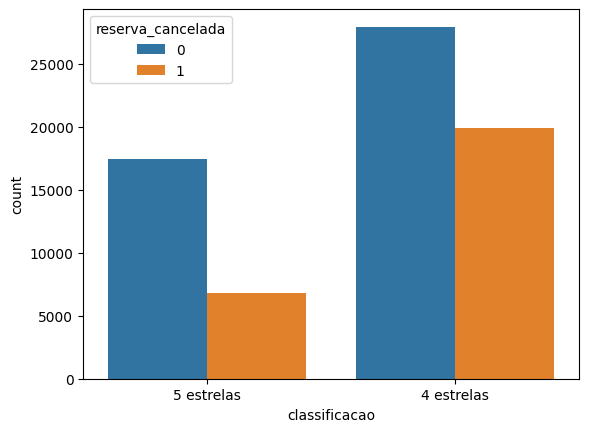

In [87]:
sns.countplot(x='classificacao', hue='reserva_cancelada', data=df4)

VERDADEIRO - Hoteis com 4 estrelas tem mais cancelamentos proporcionalmente

### 4.1.2 Hipótese do tempo de reserva: Quanto mais cedo uma reserva for feita, menor será a probabilidade de cancelamento. Por outro lado, reservas feitas com menos antecedência podem ter maiores chances de serem canceladas.

Text(0.5, 1.0, 'Proporção de reserva canceladas por não canceladas')

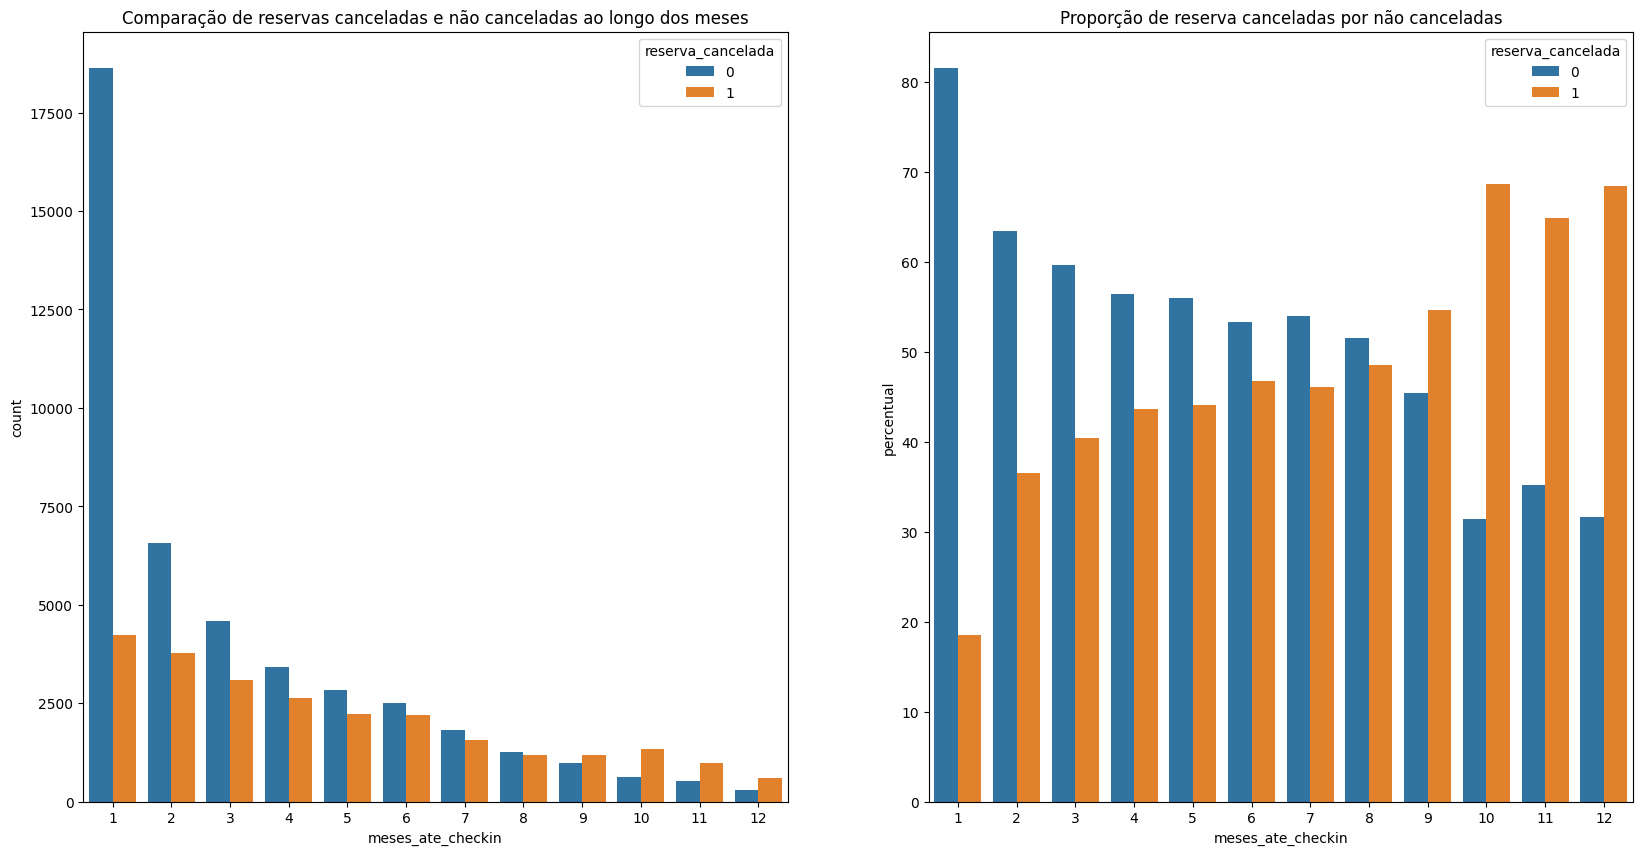

In [88]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
aux1 = df4.loc[df4['meses_ate_checkin'] <= 12,:]
sns.countplot(x='meses_ate_checkin', hue='reserva_cancelada', data=aux1)
plt.title('Comparação de reservas canceladas e não canceladas ao longo dos meses')

plt.subplot(1,2,2)
# proporcao_meses_reserva = df4.loc[(df4['meses_ate_checkin'] <= 24) & (df4['reserva_cancelada'] == 1),['meses_ate_checkin','reserva_cancelada']].groupby(['meses_ate_checkin']).count().reset_index()
# proporcao_meses_cancelamento = df4.loc[(df4['meses_ate_checkin'] <= 24) & (df4['reserva_cancelada'] == 0),['meses_ate_checkin','reserva_cancelada']].groupby(['meses_ate_checkin']).count().reset_index()
# proporcao_final = proporcao_meses_reserva['reserva_cancelada']/proporcao_meses_cancelamento['reserva_cancelada']
# proporcao_final = proporcao_final.reset_index()
# proporcao_final = proporcao_final.rename(columns={'index':'meses'})
# proporcao_final['meses'] = proporcao_final['meses'] + 1
# proporcao_final = proporcao_final.loc[proporcao_final['meses'] <=12,:]
proporcoes_meses = df4.loc[df4['meses_ate_checkin'] <=12, ['meses_ate_checkin','reserva_cancelada']].groupby('meses_ate_checkin').value_counts(normalize=True).mul(100).rename('percentual').reset_index()
sns.barplot(x='meses_ate_checkin', y='percentual', hue='reserva_cancelada', data=proporcoes_meses)
plt.title('Proporção de reserva canceladas por não canceladas')

VERDADEIRO - A proporção de cancelamentos é bem menor com reservas nos 2 primeiros meses.
a proporção começa a inverter a partir de reservas com 8 meses de antecedência. Pelo segundo gráfico podemos ver que o pico acontece no mês 10, sendo o mais que proporcionalmente tem mais cancelamentos.

### 4.1.3 Hipótese de número de pernoites: Reservas com um maior número de pernoites podem ter menores chances de serem canceladas do que reservas com menos noites.

Text(0.5, 1.0, 'Proporção de Cancelamentos por Pernoites')

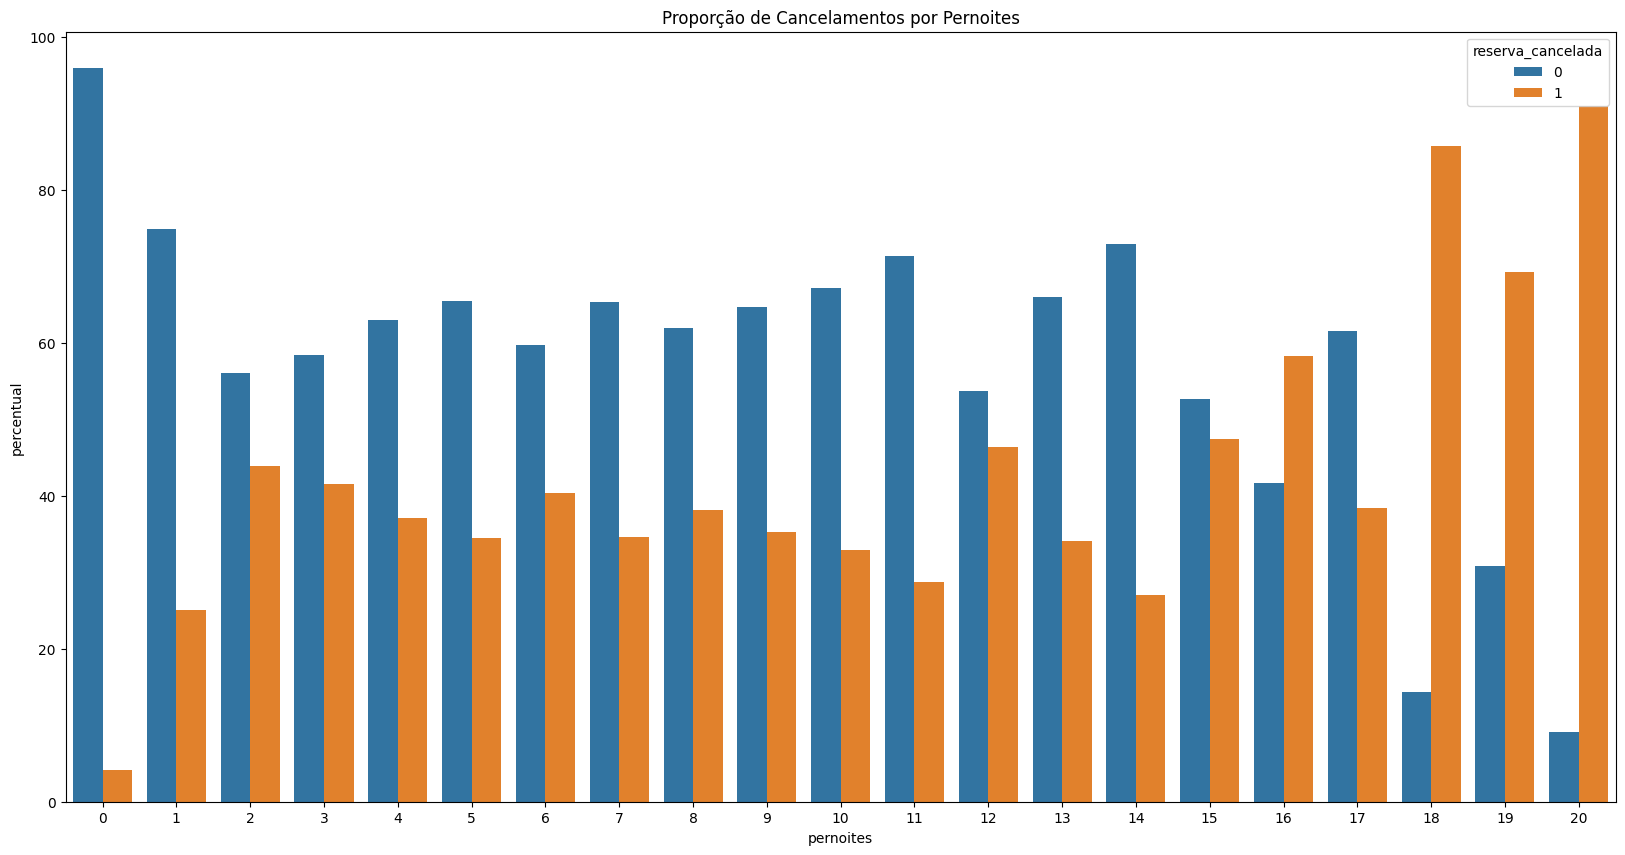

In [89]:
plt.figure(figsize=(20,10))
aux1 = df4.loc[df4['pernoites'] <= 20, ['pernoites','reserva_cancelada'] ].groupby('pernoites').value_counts(normalize=True).mul(100).rename('percentual').reset_index()
sns.barplot(x='pernoites', y='percentual', hue='reserva_cancelada', data=aux1)
plt.title('Proporção de Cancelamentos por Pernoites')

FALSO - Podemos ver que a maior quantidade de cancelamentos em relação a não cancelamentos ocorre a partir da pernoite 16

### 4.1.4 Hipótese do número de hóspedes: Reservas com um número maior de hóspedes podem ter maior probabilidade de serem canceladas.

<Axes: xlabel='hospedes', ylabel='percentual'>

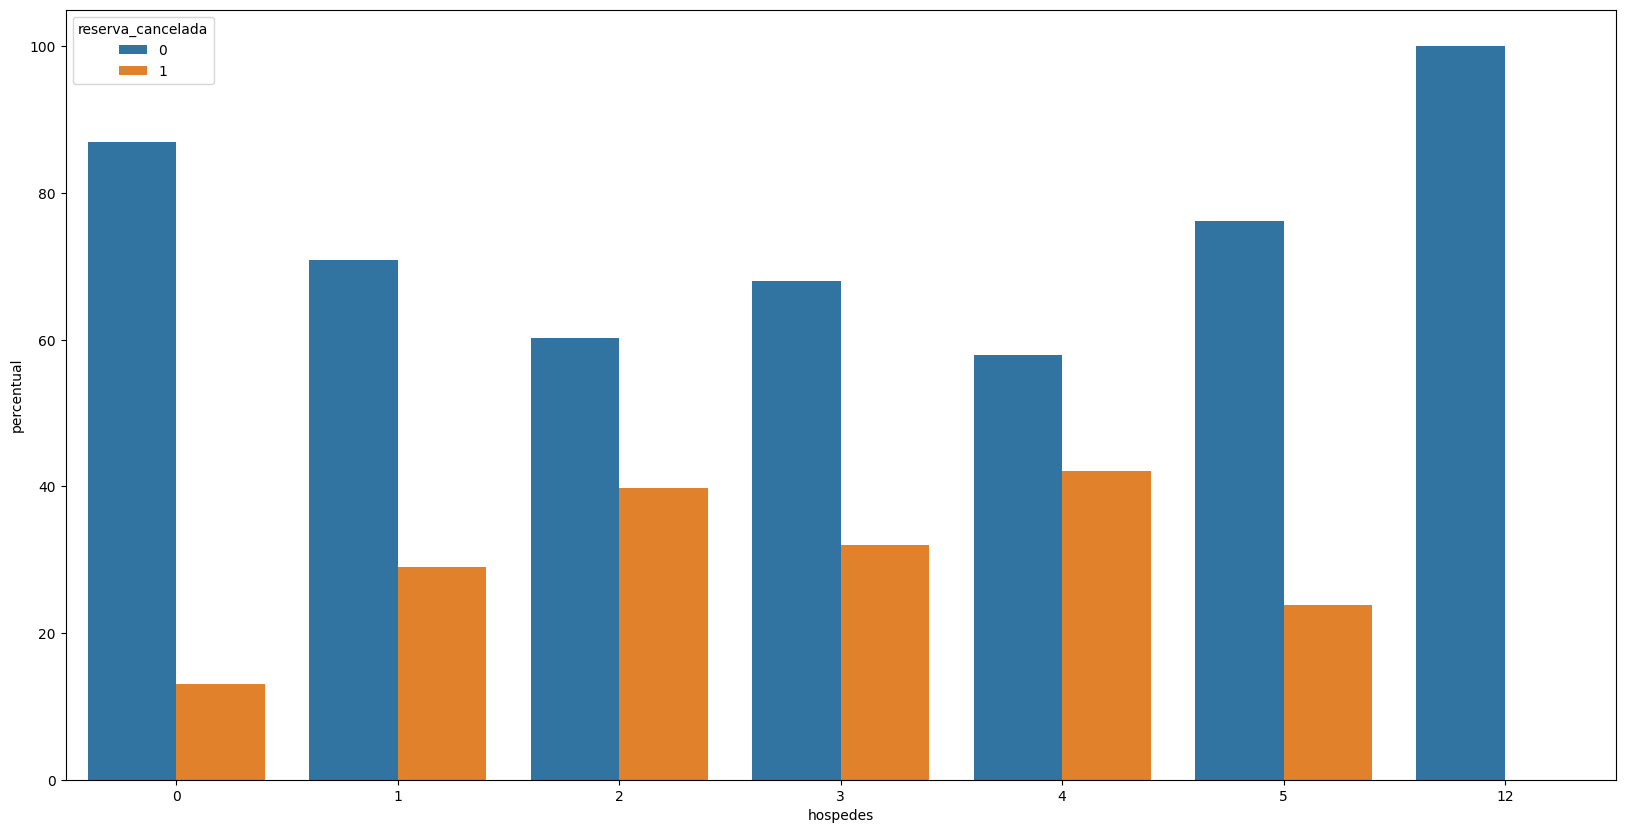

In [90]:
plt.figure(figsize=(20,10))
proporcao_hospede = df4.loc[df4['hospedes'] <= 15,['hospedes','reserva_cancelada']].groupby('hospedes').value_counts(normalize=True).mul(100).rename('percentual').reset_index()
sns.barplot(x='hospedes', y='percentual', hue='reserva_cancelada', data=proporcao_hospede)

VERDADEIRO - Podemos ver que a barra laranja tende a subir e azul a diminuir conforme o numero
de hospedes aumenta sendo que o pico aparece no número de hospedes igual a 4

### 4.1.5 Hipótese do regime de alimentação: Reservas com regime de alimentação incluído podem ter menores chances de serem canceladas do que reservas sem regime de alimentação.

<Axes: xlabel='regime_alimentacao', ylabel='percentual'>

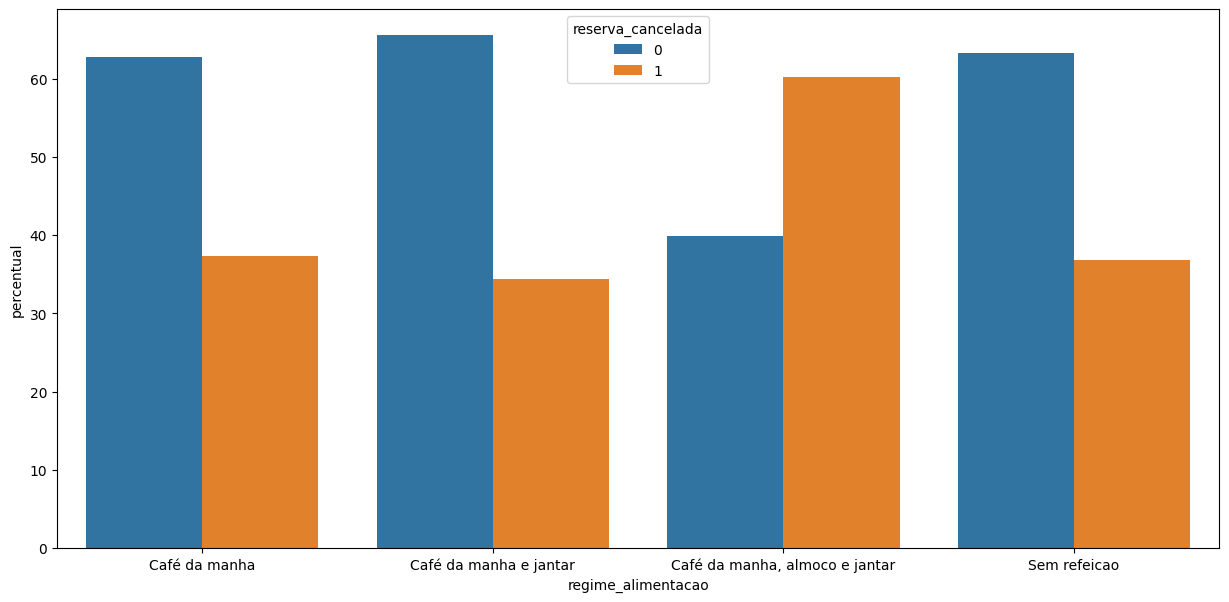

In [91]:
plt.figure(figsize=(15,7))
proporcao_alimentacao = df4.loc[:,['regime_alimentacao','reserva_cancelada']].groupby('regime_alimentacao').value_counts(normalize=True).mul(100).rename('percentual').reset_index()
sns.barplot(x='regime_alimentacao', y='percentual', hue='reserva_cancelada', data=proporcao_alimentacao)

FALSO - Existem mais reservas canceladas do que não canceladas no regime de Café da manhã, almoço e Jantar.

### 4.1.6 Hipótese da nacionalidade: Hóspedes de determinadas nacionalidades podem ter maior probabilidade de cancelar suas reservas.

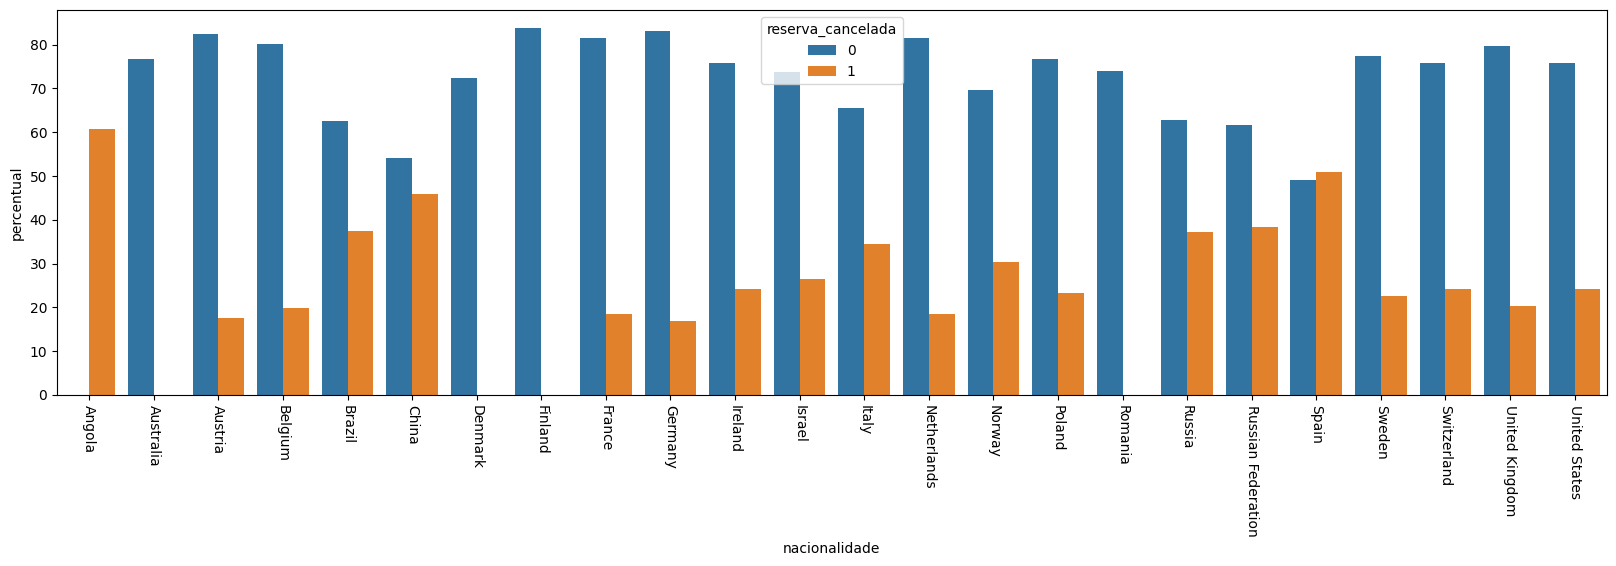

In [92]:
plt.figure(figsize=(20,5))

proporcao_nacionalidade_qtd = df4.loc[:,['nacionalidade','reserva_cancelada']].groupby('nacionalidade').value_counts().rename('quantidade').reset_index()
proporcao_nacionalidade_perc = df4.loc[:,['nacionalidade','reserva_cancelada']].groupby('nacionalidade').value_counts(normalize=True).mul(100).rename('percentual').reset_index()

prop_nac_full = pd.merge(proporcao_nacionalidade_qtd, proporcao_nacionalidade_perc)


prop_nac_full_cancelada = prop_nac_full[prop_nac_full['quantidade'] > 100]
sns.barplot(x='nacionalidade', y='percentual', hue='reserva_cancelada', data=prop_nac_full_cancelada)
plt.xticks(rotation=-90);

VERDADEIRO - Para números de reserva maior que 100, Espanha e Angola são os únicos países que possuem mais cancelamentos do que não cancelamentos. Já Finlândia, Holanda e Alemanha são os que menos cancelam

### 4.1.7 Hipótese da forma de reserva: Reservas feitas por meio de canais diferentes (como agências de turismo ou empresas) podem ter diferentes taxas de cancelamento.

<Axes: xlabel='reserva_empresa', ylabel='percentual'>

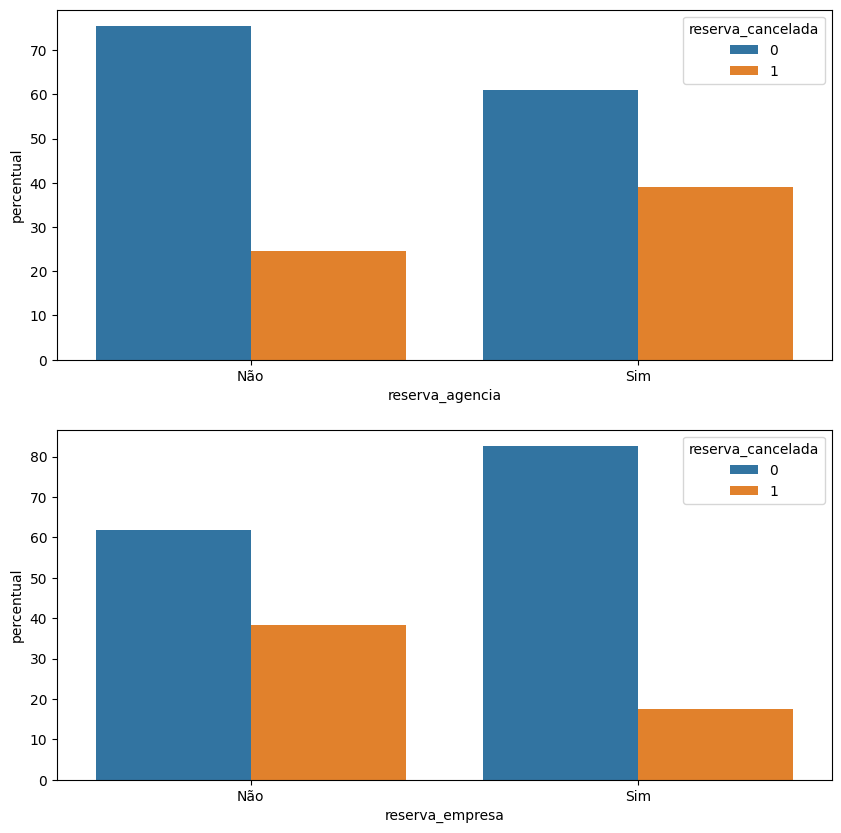

In [93]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
proporcao_agencia = df4.loc[:,['reserva_agencia','reserva_cancelada']].groupby('reserva_agencia').value_counts(normalize=True).mul(100).rename('percentual').reset_index()
sns.barplot(x='reserva_agencia', y='percentual', hue='reserva_cancelada', data=proporcao_agencia)

plt.subplot(2,1,2)
proporcao_empresa = df4.loc[:,['reserva_empresa','reserva_cancelada']].groupby('reserva_empresa').value_counts(normalize=True).mul(100).rename('percentual').reset_index()
sns.barplot(x='reserva_empresa', y='percentual', hue='reserva_cancelada', data=proporcao_empresa)

<Axes: xlabel='forma_reserva', ylabel='percentual'>

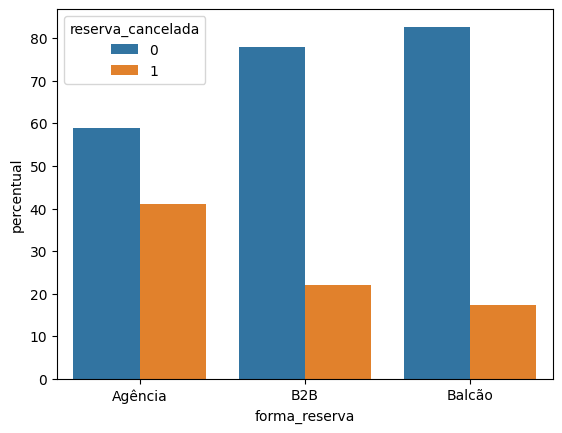

In [94]:
proporcao_forma = df4.loc[:,['forma_reserva','reserva_cancelada']].groupby('forma_reserva').value_counts(normalize=True).mul(100).rename('percentual').reset_index()
sns.barplot(x='forma_reserva', y='percentual', hue='reserva_cancelada', data=proporcao_forma)

FALSO - Reservas feitas por Agência de turismo têm muito mais chances de serem canceladas.

### 4.1.8 Hipótese da hospedagem anterior: Hóspedes que já se hospedaram anteriormente no hotel podem ter menor probabilidade de cancelar suas reservas.

<Axes: xlabel='ja_hospedou', ylabel='percentual'>

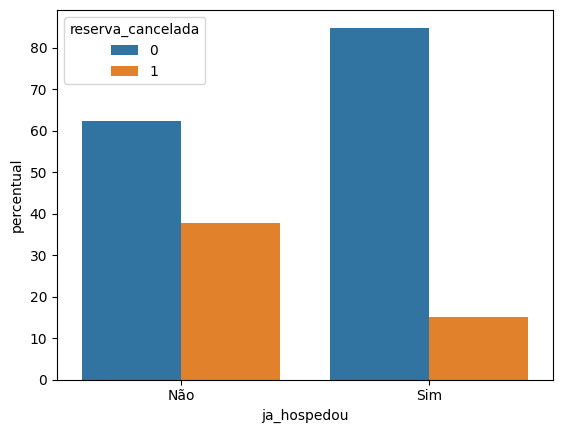

In [95]:
proporcao_hospedou = df4.loc[:,['ja_hospedou','reserva_cancelada']].groupby('ja_hospedou').value_counts(normalize=True).mul(100).rename('percentual').reset_index()
sns.barplot(x='ja_hospedou', y='percentual', hue='reserva_cancelada', data=proporcao_hospedou)


VERDADEIRO - Hospedes que já se hospedaram têm muito mais chances de não cancelarem.

### 4.1.9 Hipótese do tipo de quarto: Diferentes tipos de quarto podem ter diferentes taxas de cancelamento.

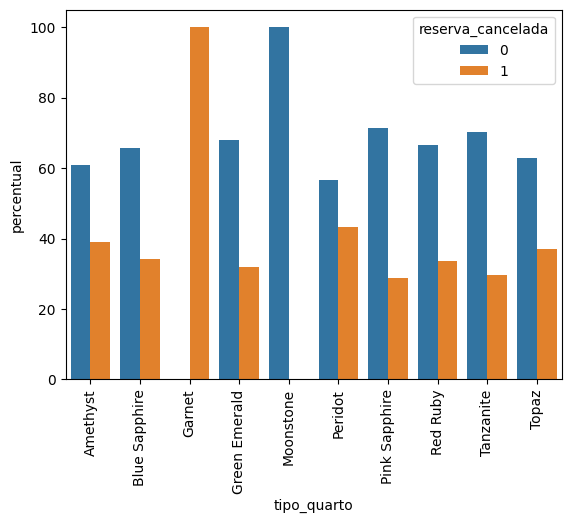

In [96]:
proporcao_quarto = df4.loc[:,['tipo_quarto','reserva_cancelada']].groupby('tipo_quarto').value_counts(normalize=True).mul(100).rename('percentual').reset_index()
sns.barplot(x='tipo_quarto', y='percentual', hue='reserva_cancelada', data=proporcao_quarto)
plt.xticks(rotation=90);

VERDADEIRO - Exceto Quarto Garnet e Moonstone que possuem poucas ocorrências, o quarto que mais tem cancelamentos em relação a não cancelamentos é o Peridot.

### 4.1.11 Hipótese da reserva com estacionamento: Reservas que incluem estacionamento podem ter menores chances de serem canceladas.

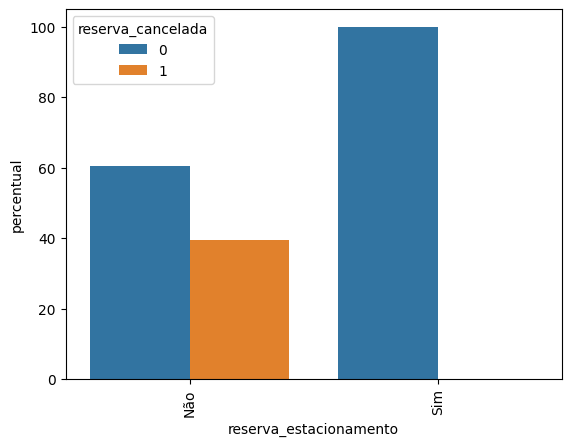

In [97]:
proporcao_estac = df4.loc[:,['reserva_estacionamento','reserva_cancelada']].groupby('reserva_estacionamento').value_counts(normalize=True).mul(100).rename('percentual').reset_index()
sns.barplot(x='reserva_estacionamento', y='percentual', hue='reserva_cancelada', data=proporcao_estac)
plt.xticks(rotation=90);

VERDADEIRO - Não existe clientes que pegaram reserva e cancelaram.

### 4.1.12 Hipótese da reserva com observações: Reservas que incluem observações específicas dos hóspedes (como solicitações especiais) podem ter menores chances de serem canceladas.

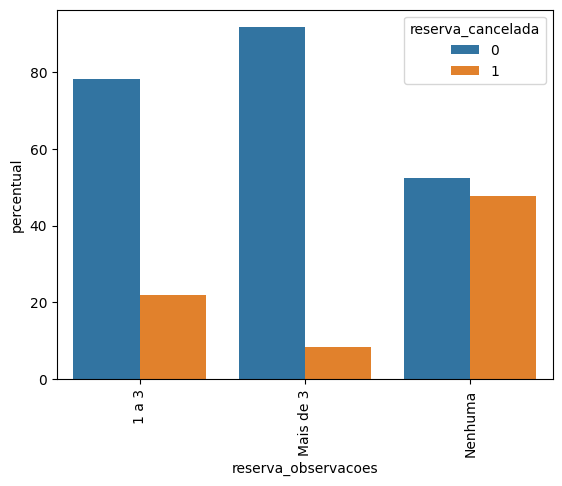

In [98]:
proporcao_obs = df4.loc[:,['reserva_observacoes','reserva_cancelada']].groupby('reserva_observacoes').value_counts(normalize=True).mul(100).rename('percentual').reset_index()
sns.barplot(x='reserva_observacoes', y='percentual', hue='reserva_cancelada', data=proporcao_obs)
plt.xticks(rotation=90);

VERDADEIRO - A maioria que pediu observações não cancelou.

## 4.2 Unilateral Analysis

In [99]:
# report = sv.analyze(source=df4, target_feat='reserva_cancelada')

# report.show_html('relatorio_sweetviz.html')
# webbrowser.open('relatorio_sweetviz.html')

## 4.3 Multilateral Analysis

<Axes: >

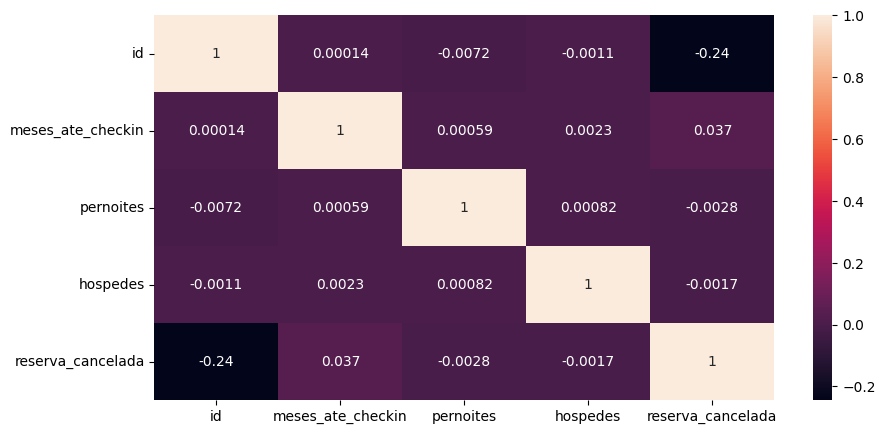

In [100]:
plt.figure(figsize=(10,5))
sns.heatmap(numerical_attributes.corr(method='pearson'), annot=True)

In [101]:
a = categorical_attributes

<Axes: >

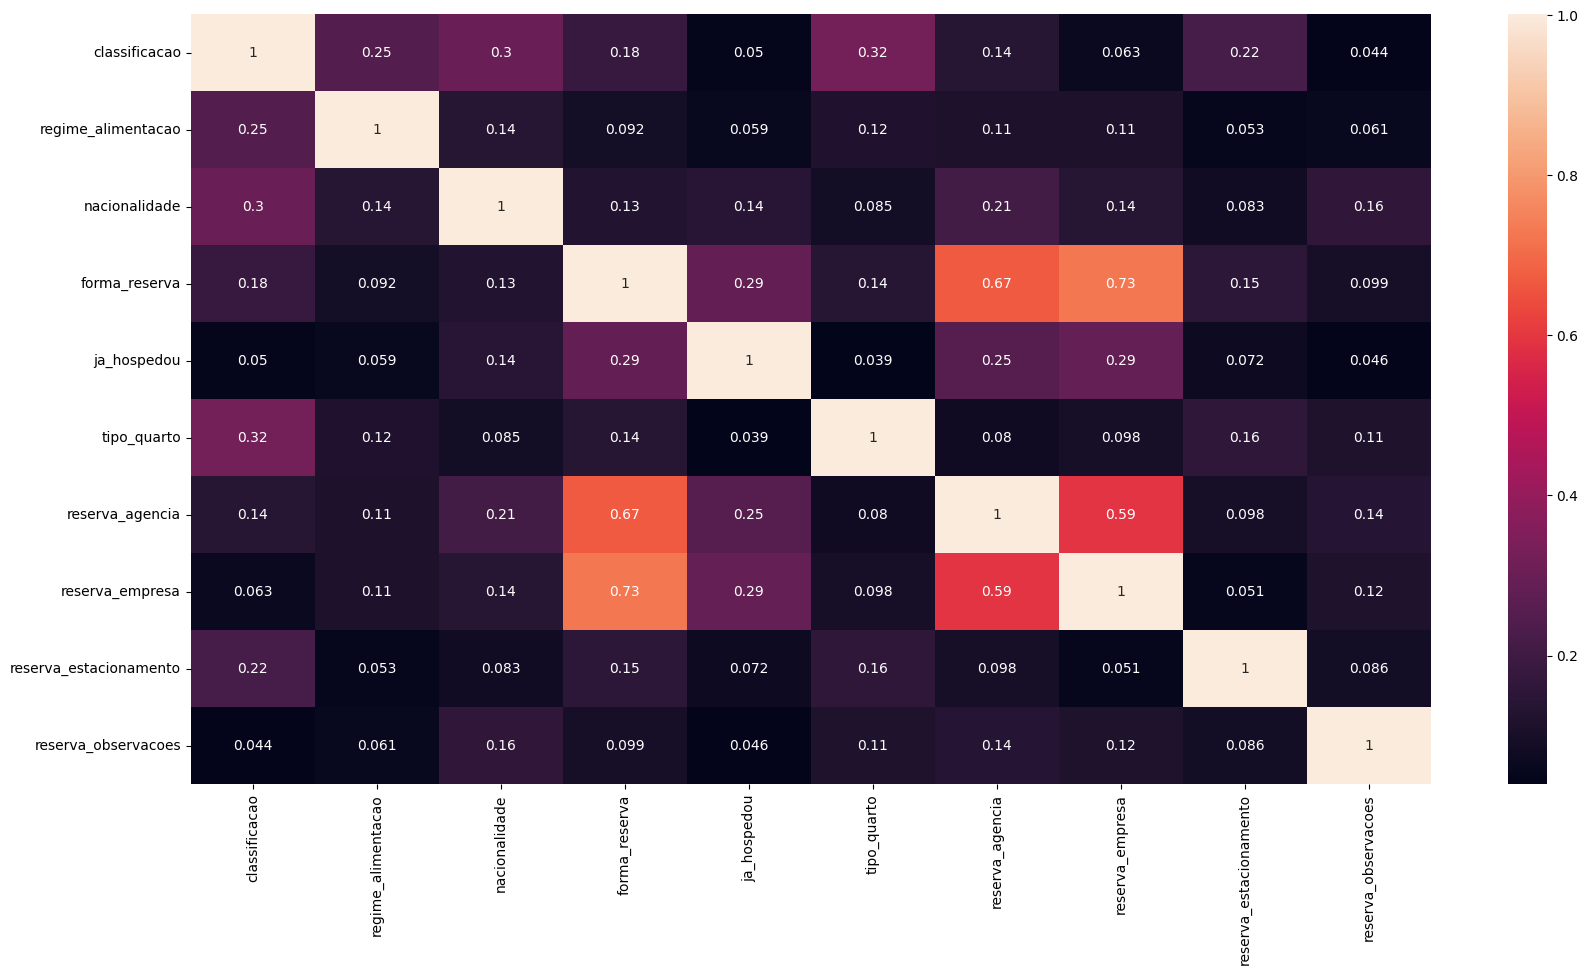

In [102]:
#Correlation Categorical Variables
a1 = cramer_v( a['classificacao'], a['classificacao'] )
a2 = cramer_v( a['classificacao'], a['regime_alimentacao'] )
a3 = cramer_v( a['classificacao'], a['nacionalidade'] )
a4 = cramer_v( a['classificacao'], a['forma_reserva'] )
a5 = cramer_v( a['classificacao'], a['ja_hospedou'] )
a6 = cramer_v( a['classificacao'], a['tipo_quarto'] )
a7 = cramer_v( a['classificacao'], a['reserva_agencia'] )
a8 = cramer_v( a['classificacao'], a['reserva_empresa'] )
a9 = cramer_v( a['classificacao'], a['reserva_estacionamento'] )
a10 = cramer_v( a['classificacao'], a['reserva_observacoes'] )

a11 = cramer_v( a['regime_alimentacao'], a['classificacao'] )
a12 = cramer_v( a['regime_alimentacao'], a['regime_alimentacao'] )
a13 = cramer_v( a['regime_alimentacao'], a['nacionalidade'] )
a14 = cramer_v( a['regime_alimentacao'], a['forma_reserva'] )
a15 = cramer_v( a['regime_alimentacao'], a['ja_hospedou'] )
a16 = cramer_v( a['regime_alimentacao'], a['tipo_quarto'] )
a17 = cramer_v( a['regime_alimentacao'], a['reserva_agencia'] )
a18 = cramer_v( a['regime_alimentacao'], a['reserva_empresa'] )
a19 = cramer_v( a['regime_alimentacao'], a['reserva_estacionamento'] )
a20 = cramer_v( a['regime_alimentacao'], a['reserva_observacoes'] )

a21 = cramer_v( a['nacionalidade'], a['classificacao'] )
a22 = cramer_v( a['nacionalidade'], a['regime_alimentacao'] )
a23 = cramer_v( a['nacionalidade'], a['nacionalidade'] )
a24 = cramer_v( a['nacionalidade'], a['forma_reserva'] )
a25 = cramer_v( a['nacionalidade'], a['ja_hospedou'] )
a26 = cramer_v( a['nacionalidade'], a['tipo_quarto'] )
a27 = cramer_v( a['nacionalidade'], a['reserva_agencia'] )
a28 = cramer_v( a['nacionalidade'], a['reserva_empresa'] )
a29 = cramer_v( a['nacionalidade'], a['reserva_estacionamento'] )
a30 = cramer_v( a['nacionalidade'], a['reserva_observacoes'] )

a31 = cramer_v( a['forma_reserva'], a['classificacao'] )
a32 = cramer_v( a['forma_reserva'], a['regime_alimentacao'] )
a33 = cramer_v( a['forma_reserva'], a['nacionalidade'] )
a34 = cramer_v( a['forma_reserva'], a['forma_reserva'] )
a35 = cramer_v( a['forma_reserva'], a['ja_hospedou'] )
a36 = cramer_v( a['forma_reserva'], a['tipo_quarto'] )
a37 = cramer_v( a['forma_reserva'], a['reserva_agencia'] )
a38 = cramer_v( a['forma_reserva'], a['reserva_empresa'] )
a39 = cramer_v( a['forma_reserva'], a['reserva_estacionamento'] )
a40 = cramer_v( a['forma_reserva'], a['reserva_observacoes'] )

a41 = cramer_v( a['ja_hospedou'], a['classificacao'] )
a42 = cramer_v( a['ja_hospedou'], a['regime_alimentacao'] )
a43 = cramer_v( a['ja_hospedou'], a['nacionalidade'] )
a44 = cramer_v( a['ja_hospedou'], a['forma_reserva'] )
a45 = cramer_v( a['ja_hospedou'], a['ja_hospedou'] )
a46 = cramer_v( a['ja_hospedou'], a['tipo_quarto'] )
a47 = cramer_v( a['ja_hospedou'], a['reserva_agencia'] )
a48 = cramer_v( a['ja_hospedou'], a['reserva_empresa'] )
a49 = cramer_v( a['ja_hospedou'], a['reserva_estacionamento'] )
a50 = cramer_v( a['ja_hospedou'], a['reserva_observacoes'] )

a51 = cramer_v( a['tipo_quarto'], a['classificacao'] )
a52 = cramer_v( a['tipo_quarto'], a['regime_alimentacao'] )
a53 = cramer_v( a['tipo_quarto'], a['nacionalidade'] )
a54 = cramer_v( a['tipo_quarto'], a['forma_reserva'] )
a55 = cramer_v( a['tipo_quarto'], a['ja_hospedou'] )
a56 = cramer_v( a['tipo_quarto'], a['tipo_quarto'] )
a57 = cramer_v( a['tipo_quarto'], a['reserva_agencia'] )
a58 = cramer_v( a['tipo_quarto'], a['reserva_empresa'] )
a59 = cramer_v( a['tipo_quarto'], a['reserva_estacionamento'] )
a60 = cramer_v( a['tipo_quarto'], a['reserva_observacoes'] )

a61 = cramer_v( a['reserva_agencia'], a['classificacao'] )
a62 = cramer_v( a['reserva_agencia'], a['regime_alimentacao'] )
a63 = cramer_v( a['reserva_agencia'], a['nacionalidade'] )
a64 = cramer_v( a['reserva_agencia'], a['forma_reserva'] )
a65 = cramer_v( a['reserva_agencia'], a['ja_hospedou'] )
a66 = cramer_v( a['reserva_agencia'], a['tipo_quarto'] )
a67 = cramer_v( a['reserva_agencia'], a['reserva_agencia'] )
a68 = cramer_v( a['reserva_agencia'], a['reserva_empresa'] )
a69 = cramer_v( a['reserva_agencia'], a['reserva_estacionamento'] )
a70 = cramer_v( a['reserva_agencia'], a['reserva_observacoes'] )

a71 = cramer_v( a['reserva_empresa'], a['classificacao'] )
a72 = cramer_v( a['reserva_empresa'], a['regime_alimentacao'] )
a73 = cramer_v( a['reserva_empresa'], a['nacionalidade'] )
a74 = cramer_v( a['reserva_empresa'], a['forma_reserva'] )
a75 = cramer_v( a['reserva_empresa'], a['ja_hospedou'] )
a76 = cramer_v( a['reserva_empresa'], a['tipo_quarto'] )
a77 = cramer_v( a['reserva_empresa'], a['reserva_agencia'] )
a78 = cramer_v( a['reserva_empresa'], a['reserva_empresa'] )
a79 = cramer_v( a['reserva_empresa'], a['reserva_estacionamento'] )
a80 = cramer_v( a['reserva_empresa'], a['reserva_observacoes'] )

a81 = cramer_v( a['reserva_estacionamento'], a['classificacao'] )
a82 = cramer_v( a['reserva_estacionamento'], a['regime_alimentacao'] )
a83 = cramer_v( a['reserva_estacionamento'], a['nacionalidade'] )
a84 = cramer_v( a['reserva_estacionamento'], a['forma_reserva'] )
a85 = cramer_v( a['reserva_estacionamento'], a['ja_hospedou'] )
a86 = cramer_v( a['reserva_estacionamento'], a['tipo_quarto'] )
a87 = cramer_v( a['reserva_estacionamento'], a['reserva_agencia'] )
a88 = cramer_v( a['reserva_estacionamento'], a['reserva_empresa'] )
a89 = cramer_v( a['reserva_estacionamento'], a['reserva_estacionamento'] )
a90 = cramer_v( a['reserva_estacionamento'], a['reserva_observacoes'] )

a91 = cramer_v( a['reserva_observacoes'], a['classificacao'] )
a92 = cramer_v( a['reserva_observacoes'], a['regime_alimentacao'] )
a93 = cramer_v( a['reserva_observacoes'], a['nacionalidade'] )
a94 = cramer_v( a['reserva_observacoes'], a['forma_reserva'] )
a95 = cramer_v( a['reserva_observacoes'], a['ja_hospedou'] )
a96 = cramer_v( a['reserva_observacoes'], a['tipo_quarto'] )
a97 = cramer_v( a['reserva_observacoes'], a['reserva_agencia'] )
a98 = cramer_v( a['reserva_observacoes'], a['reserva_empresa'] )
a99 = cramer_v( a['reserva_observacoes'], a['reserva_estacionamento'] )
a100 = cramer_v( a['reserva_observacoes'], a['reserva_observacoes'] )



# Final dataset
d = pd.DataFrame( {'classificacao': [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10], 
               'regime_alimentacao': [a11, a12, a13, a14, a15, a16, a17, a18, a19, a20],
               'nacionalidade': [a21, a22, a23, a24, a25, a26, a27, a28, a29, a30],
                'forma_reserva': [a31, a32, a33, a34, a35, a36, a37, a38, a39, a40],
                   'ja_hospedou': [a41, a42, a43, a44, a45, a46, a47, a48, a49, a50],
                   'tipo_quarto': [a51, a52, a53, a54, a55, a56, a57, a58, a59, a60],
                   'reserva_agencia': [a61, a62, a63, a64, a65, a66, a67, a68, a69, a70],
                   'reserva_empresa': [a71, a72, a73, a74, a75, a76, a77, a78, a79, a80],
                   'reserva_estacionamento': [a81, a82, a83, a84, a85, a86, a87, a88, a89, a90],
                   'reserva_observacoes': [a91, a92, a93, a94, a95, a96, a97, a98, a99, a100]})
d = d.set_index( d.columns )
plt.figure(figsize=(20,10))
sns.heatmap( d, annot=True )

# 5.0 DATA PREPARATION

In [103]:
df5 = df4.copy()

In [104]:
df5.sample(20).T

,40868,52780,32902,38350,61835,53937,66411,17219,65093,568,38545,43743,63578,43934,58344,53052,27766,59900,33323,31520
id,54735,83611,6967,48522,110847,38365,67150,37627,49418,32375,47782,48517,64497,43052,97694,21629,96730,61436,76133,26691
classificacao,4 estrelas,4 estrelas,5 estrelas,4 estrelas,4 estrelas,5 estrelas,4 estrelas,5 estrelas,4 estrelas,5 estrelas,4 estrelas,4 estrelas,4 estrelas,4 estrelas,4 estrelas,5 estrelas,4 estrelas,4 estrelas,4 estrelas,5 estrelas
meses_ate_checkin,13,1,10,3,5,5,4,1,4,2,3,2,1,2,2,1,7,2,9,7
pernoites,2,2,7,5,2,2,4,2,1,3,2,3,5,2,2,7,3,3,2,4
hospedes,2,2,2,2,2,2,2,2,2,1,2,3,2,2,2,2,2,2,2,2
regime_alimentacao,Café da manha,Sem refeicao,Café da manha,Sem refeicao,Café da manha,Café da manha,Café da manha,Café da manha,Café da manha,Sem refeicao,Café da manha,Café da manha,Café da manha,Café da manha e jantar,Café da manha,Café da manha,Café da manha,Café da manha,Café da manha e jantar,Café da manha
nacionalidade,Spain,Brazil,Spain,Netherlands,Israel,"Taiwan, Province of China",Spain,Spain,Spain,Spain,Spain,Spain,Spain,Spain,Spain,Russian Federation,Czech Republic,Spain,Spain,Spain
forma_reserva,Agência,Agência,Agência,Agência,Agência,Agência,Agência,Agência,Agência,Balcão,Agência,Agência,Agência,Agência,Agência,Agência,Agência,Agência,Agência,Agência
ja_hospedou,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não
tipo_quarto,Amethyst,Amethyst,Amethyst,Amethyst,Amethyst,Amethyst,Amethyst,Green Emerald,Amethyst,Amethyst,Amethyst,Green Emerald,Amethyst,Amethyst,Amethyst,Amethyst,Amethyst,Amethyst,Amethyst,Amethyst


## 5.1 Removing Outliers

In [105]:
#hospedes
df5['hospedes'] = df5['hospedes'].apply(lambda x: 5 if x > 5 else x)

#meses_ate_checkin
df5['meses_ate_checkin'] = df5['meses_ate_checkin'].apply(lambda x: 12 if x > 12 else x)

#pernoites
df5['pernoites'] = df5['pernoites'].apply(lambda x: 20 if x > 20 else x)


## 5.2 Transform

In [106]:
df5 = data_transformation(df5)

## 5.3 Encoding

In [107]:
df5 = data_encoding(df5)

# 6.0 FEATURE SELECTION

## 6.1 Split Validation and Train

In [108]:
df6 = df5.copy()

In [109]:
df6.head().T

,0,1,2,3,4
id,0.279136,0.685633,0.782113,0.625249,0.689641
classificacao,5.000000,4.000000,4.000000,4.000000,4.000000
meses_ate_checkin,0.400000,1.800000,0.200000,1.800000,0.200000
pernoites,1.000000,0.000000,0.000000,-0.500000,-0.500000
hospedes,0.000000,0.000000,0.000000,0.000000,0.000000
nacionalidade,0.086628,0.489267,0.020289,0.489267,0.489267
ja_hospedou,0.000000,0.000000,0.000000,0.000000,0.000000
tipo_quarto,0.717554,0.717554,0.717554,0.717554,0.717554
reserva_agencia,1.000000,1.000000,1.000000,1.000000,1.000000
reserva_empresa,0.000000,0.000000,0.000000,0.000000,0.000000


In [110]:
X = df6.copy()
y = df6['reserva_cancelada']

X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.25, random_state=42)
X_train = X_train.drop('reserva_cancelada', axis=1)

## 6.2 Boruta

In [111]:
rf = RandomForestClassifier(n_jobs=-1)

In [112]:
X_train_n = X_train.values
y_train_n = y_train.values

In [113]:
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [114]:
# cols_boruta = boruta.support_
# cols_boruta

## 6.3 ExtraTree

In [115]:
# et = ExtraTreesClassifier(n_jobs=-1)

# et.fit(X_train_n, y_train_n)

In [116]:
# importance = et.feature_importances_

In [117]:
# features = pd.DataFrame(importance).reset_index()
# cols_x_train = pd.DataFrame(X_train.columns).reset_index()

In [118]:
# order_features = pd.merge(cols_x_train, features, on='index')
# order_features = order_features.rename(columns={'0_x':'Feature', '0_y':'Importance'})
# order_features.drop('index', axis=1)
# order_features.sort_values(by='Importance', ascending=False)

In [119]:
cols_selected_tree = ['id', 'nacionalidade', 'meses_ate_checkin', 'pernoites',
       'classificacao', 'obs_nenhuma', 'reserva_estacionamento', 'obs_1_a_3',
       'hospedes', 'forma_reserva_agencia', 'tipo_quarto','forma_reserva_balcao']

# 7.0 MACHINE LEARNING

In [54]:
x_train = X_train.loc[:,cols_selected_tree]
x_val = X_val.loc[:,cols_selected_tree]

In [55]:
X_train.head().T

,24653,70034,28938,64197,35979
id,0.406921,0.097411,0.398964,0.998952,0.353231
classificacao,4.000000,5.000000,4.000000,4.000000,4.000000
meses_ate_checkin,-0.200000,-0.200000,-0.400000,0.200000,-0.400000
pernoites,0.500000,-1.000000,0.000000,0.500000,-0.500000
hospedes,0.000000,0.000000,-1.000000,0.000000,0.000000
nacionalidade,0.010782,0.007774,0.489267,0.086628,0.489267
ja_hospedou,0.000000,0.000000,0.000000,0.000000,0.000000
tipo_quarto,0.009327,0.717554,0.717554,0.163500,0.717554
reserva_agencia,1.000000,1.000000,1.000000,1.000000,1.000000
reserva_empresa,0.000000,0.000000,0.000000,0.000000,0.000000


## Testing models

In [56]:
model_list = [  DummyClassifier(),
                LogisticRegression(),
                DecisionTreeClassifier(),
                KNeighborsClassifier(),
                GaussianNB(),
                RandomForestClassifier(),
                XGBClassifier()]

In [57]:
for model in model_list:
    model.fit(x_train, y_train)
    score = model.score(x_val, y_val)
    print(f'{model}: Score: {score:.3f}%')

DummyClassifier(): Score: 0.634%


C:\Users\edils\anaconda3\envs\hotel_chain_cancellation\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(): Score: 0.848%
DecisionTreeClassifier(): Score: 0.965%
KNeighborsClassifier(): Score: 0.904%
GaussianNB(): Score: 0.473%
RandomForestClassifier(): Score: 0.970%
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...): Score: 0.970%


## 7.1 KNN

In [58]:
model_knn = KNeighborsClassifier(n_neighbors=3)

model_knn.fit(x_train, y_train)

yhat_knn = model_knn.predict(x_val)


In [59]:
model_performance('KNN', yhat_knn, y_val)

 KNN F1 Macro: 90.22%
 KNN Acurácia: 90.92%
 KNN Precision: 87.70%
 KNN Recall: 87.48%


## 7.2 Random Forest

In [ ]:
model_rf = RandomForestClassifier(n_jobs=-1)

model_rf.fit(x_train, y_train)

yhat_rf = model_rf.predict(x_val)

In [ ]:
model_performance('Random Forest', yhat_rf, y_val)

## 7.3 XGBoost

In [ ]:
model_xgb = XGBClassifier()

model_xgb.fit(x_train, y_train)

yhat_xgb = model_xgb.predict(x_val)

In [ ]:
model_performance('XGBoost', yhat_xgb, y_val)

## 7.5 Cross Validation

In [ ]:
#Pontuação Random Forest
pontuacao_rf = ms.cross_val_score(model_rf, X, y, cv=10, n_jobs=-1)


In [ ]:
np.mean(pontuacao_rf)

In [ ]:
#Pontuação XGBoost
pontuacao_xgb = ms.cross_val_score(model_xgb, X, y, cv=10, n_jobs=-1)

In [ ]:

np.mean(pontuacao_xgb)

## 7.6 Fine Tunning

### 7.6.1 Random Search

In [ ]:


# param_distributions = {'max_depth': [2, 4, 6, 8, 9], 
#                        'learning_rate': [0.01, 0.05, 0.10, 0.2, 0.4], 
#                        'n_estimators': [1200, 1800, 2500, 3500, 5000], 
#                        'subsample': [0.1, 0.25, 0.5, 0.75, 1.0], 
#                        'colsample_bytree':[0.1, 0.25, 0.5, 0.75, 1.0]}
# #RandomSearch Dfinition
# random_search = RandomizedSearchCV(model_xgb, param_distributions=param_distributions, n_iter=5, cv=5)

# random_search.fit(x_train, y_train)

In [ ]:
# best_params = random_search.best_params_
# best_score = random_search.best_score_

# print(best_params)
# print(best_score)

## 7.7 XGBoost Best Parameters

In [63]:
xgb_tunned = XGBClassifier(n_estimators=1800, max_depth=8, learning_rate=0.05, colsample_bytree=0.5, subsample=0.75)

# 8.0 MODEL PERFORMANCE

## 8.1 Cleaning Test Data

In [ ]:
X_test = pd.read_csv(path + 'test.csv')

In [ ]:
X_test.head()

In [ ]:
X_test = rename_columns(X_test)
X_test = na_fill(X_test)
X_test = change_types(X_test)
X_test = data_transformation(X_test)
X_test = data_encoding(X_test)

In [ ]:
x_test = X_test.loc[:, cols_selected_tree]

In [ ]:
x = X.loc[:,cols_selected_tree]

## 8.2 Testing on Raw Data

In [ ]:
xgb_tunned.fit(x, y)

yhat_xgb_tunned = xgb_tunned.predict(x_test)

## 8.2 Submissão

In [ ]:
submission = pd.read_csv(path + 'submission.csv')
submission['Reserva Cancelada'] = yhat_xgb_tunned
submission.to_csv('submissão_terceira_train_val_merge.csv', index=False)

# 9.0 Deploy to Production

In [66]:
pickle.dump( xgb_tunned, open ('C:/Users/edils/repos/hotel_chain_cancellation/src/models/model_xgb.pkl', 'wb'))

## 9.1 Hotel Chain Cancellation Class

In [120]:
class HotelCancellation:
    def __init__(self):
        self.home_path                = 'C:/Users/edils/repos/hotel_chain_cancellation/'
        
        self.hospedes_scaler          = pickle.load(open(self.home_path + 'src/features/hospedes_scaler.pkl', 'rb'))
        self.id_scaler                = pickle.load(open(self.home_path + 'src/features/id_scaler.pkl', 'rb'))        
        self.meses_ate_checkin_scaler = pickle.load(open(self.home_path + 'src/features/meses_ate_checkin_scaler.pkl', 'rb'))        
        self.nacionalidade_scaler     = pickle.load(open(self.home_path + 'src/features/nacionalidade_scaler.pkl', 'rb'))        
        self.pernoites_scaler         = pickle.load(open(self.home_path + 'src/features/pernoites_scaler.pkl', 'rb'))        
        self.tipo_quarto_scaler       = pickle.load(open(self.home_path + 'src/features/tipo_quarto_scaler.pkl', 'rb')) 
        
    def rename_columns(df1):
    valores_dict = ['id',
                'classificacao', 
                'meses_ate_checkin', 
                'pernoites', 
                'hospedes', 
                'regime_alimentacao',
                'nacionalidade', 
                'forma_reserva', 
                'ja_hospedou',
                'tipo_quarto',
                'reserva_agencia',
                'reserva_empresa',
                'reserva_estacionamento',
                'reserva_observacoes',
                'reserva_cancelada']

    chaves_dict = df1.columns
    cols_new = dict(zip(chaves_dict,valores_dict))
    df1 = df1.rename(columns=cols_new)
    return df1    
        
        